# A Primer on Acoustic Analysis
## Simple methods to analyze and visualize multispecies acoustic datasets

## Part 1: Signal Space Partitioning in Wren-Warblers

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt
import pingouin as pg
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

#### Load the .csv file and create a dataframe

In [2]:
filename = 'sample_dataset_prinia_project.csv'
df = pd.read_csv(filename)

In [3]:
df.head()

,AE,BT,BW,CF,DT,ET,GL,HF,LF,NT,P,PF,PFC,PFCM,PFCm,SC
0,3.946,3.022712,1464.3,5512.5,0.074172,3.096884,Y,6728.563,3201.9,19.0,G,5598.6,5943.2;5684.8;5598.6;5512.5;5684.8;5168.0;5598...,6373.8,3962.1,S
1,4.009,6.367048,2670.1,5254.1,0.081072,6.448120,N,6496.544,2969.8,19.0,G,5340.2,3014.6;5857.0;5598.6;5340.2;5340.2;5340.2;5340...,6373.8,3014.6,S
2,3.905,20.208960,1378.1,5254.1,0.087971,20.296932,Y,6914.178,3201.9,19.0,G,5340.2,5684.8;5426.4;5168.0;5512.5;5340.2;5340.2;5340...,5943.2,4048.2,S
3,3.690,24.681960,1378.1,5512.5,0.081072,24.763032,Y,6357.332,3062.7,19.0,G,5598.6,5598.6;5598.6;5598.6;5598.6;5598.6;5598.6;5426...,6287.7,4737.3,S
4,3.850,28.597960,1292.0,5340.2,0.079347,28.677307,N,6310.928,2969.8,19.0,G,5340.2,5598.6;5340.2;5254.1;5254.1;5340.2;5340.2;5340...,6287.7,3273.0,S


#### Generate dataset which contains the parameters of interest for a given note

Sample dataset: comprises of multiple notes labelled in Raven Pro (Cornell Lab of Ornithology) for four species of Wren-Warblers (genus _Prinia_)

*Note*: The analysis is non phylogenetic due to the absence of phylogeny for Prinia species

**Parameters measured:**
1. Average Entropy (AE)
2. Begin Time (BT)
3. End Time (ET)
4. 90% Bandwidth (BW)
5. Center Frequency (CF)
6. Delta Time (DT)
7. Highest Frequency (HF)
8. Lowest Frequency (LF)
9. Mean Peak Frequency (PF)
10. Maximum Peak Frequency (MPFC)
11. Minimum Peak Frequency (mPFC)
12. Peak Frequency Contour (PFC)

**Labels:**
1. Song/Call (SC)
2. Good Label (GL) (Based on signal to noise ratio in spectrogram)
3. Prinia Species (P)
4. Note Type (NT) - arbitrarily hand labelled and visually clustered

**Four Prinia Species:**
1. Ashy Prinia
2. Grey Breasted Prinia
3. Plain Prinia
4. Jungle Prinia

*Note*: PFC captures the 'shape' of the note. The first and last values of the PFC contour are a good representation of whether the signal is an upsweep, a downsweep etc.

In [4]:
def extract_first(PFC):
    PFC_f = PFC.split(';')[0]
    
    return PFC_f
def extract_last(PFC):
    PFC_l = PFC.split(';')[-1]
    return PFC_l

In [5]:
df['PFCs'] = df['PFC'].apply(extract_first)
df['PFCs'] = pd.to_numeric(df['PFCs'], errors='coerce').astype('float64')

In [6]:
df['PFCe'] = df['PFC'].apply(extract_last)
df['PFCe'] = pd.to_numeric(df['PFCe'], errors='coerce').astype('float64')

In [7]:
df['Pn'] = df['P'].copy()
df['Pn'] = df['Pn'].replace({'A':1, 'G':2, 'J':3, 'P':4});

_Features that form the multidimensional acoustic space:_
1. Average Entropy
2. Bandwidth
3. Center Frequency
4. Delta Time
5. Peak Frequency
6. First value of the Peak Frequency Contour
7. Last value of the Peak Frequency Contour
8. Maximum value of the Peak Frequency Contour
9. Minimum value of the Peak Frequency Contour

In [8]:
data = df[['AE', 'BW', 'CF', 'DT', 'PF', 'PFCs', 'PFCe', 'PFCM', 'PFCm','Pn','SC','GL','P','NT']]
features = ['AE', 'BW', 'CF', 'DT', 'PF', 'PFCs', 'PFCe', 'PFCM', 'PFCm']

#### Seperate song and call data

In [9]:
def song_extract(data):
    data.dropna()
    df = data[(data['SC']=='S')&(data['GL']=='Y')]
    return df
def call_extract(data):
    data.dropna()
    df = data[data['SC']=='C'] #&(data['GL']=='Y') if the sample size is high
    return df

In [10]:
song_data = song_extract(data); call_data = call_extract(data)
song_data = song_data.reset_index(drop = True)
song_data = song_data.drop(['GL'],axis = 1)
song_data.head()

,AE,BW,CF,DT,PF,PFCs,PFCe,PFCM,PFCm,Pn,SC,P,NT
0,3.946,1464.3,5512.5,0.074172,5598.6,5943.2,4478.9,6373.8,3962.1,2,S,G,19.0
1,3.905,1378.1,5254.1,0.087971,5340.2,5684.8,4048.2,5943.2,4048.2,2,S,G,19.0
2,3.690,1378.1,5512.5,0.081072,5598.6,5598.6,4737.3,6287.7,4737.3,2,S,G,19.0
3,3.849,1722.7,5512.5,0.087971,5598.6,6029.3,5340.2,6632.2,5081.8,2,S,G,19.0
4,3.824,2670.1,5426.4,0.098321,5684.8,4048.2,3617.6,6890.6,3617.6,2,S,G,19.0


#### Ashy Prinia Song 
Descriptions for various parameters:

In [11]:
song_data.loc[song_data['P']=='A',features].describe()

,AE,BW,CF,DT,PF,PFCs,PFCe,PFCM,PFCm
count,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000,1799.000000
mean,2.651496,2169.463646,4985.450361,0.169481,5137.609672,4394.440411,4996.081267,6279.896109,3648.304225
std,0.291085,525.769076,348.619380,0.033871,597.630611,836.286636,891.214255,410.122664,415.880385
min,1.879000,602.900000,3962.100000,0.067000,3359.200000,2756.200000,2670.100000,4737.300000,2411.700000
25%,2.445000,1894.900000,4737.300000,0.158000,4651.200000,3789.800000,4565.000000,5943.200000,3359.200000
50%,2.640000,2239.500000,4995.700000,0.177000,5081.800000,4134.400000,5081.800000,6373.800000,3703.700000
75%,2.842000,2497.900000,5168.000000,0.190000,5512.500000,4823.400000,5426.400000,6546.100000,3876.000000
max,3.667000,3531.400000,6287.700000,0.244000,6804.500000,7407.400000,6632.200000,7838.100000,4909.600000


#### Grey Breasted Prinia Song

In [12]:
song_data.loc[song_data['P']=='G',features].describe()

,AE,BW,CF,DT,PF,PFCs,PFCe,PFCM,PFCm
count,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000
mean,3.339369,1822.514454,5572.528097,0.089029,5584.912242,5783.922419,5073.321386,6529.901917,4549.471165
std,0.778186,909.489741,634.814138,0.038946,771.561840,889.411200,1017.637853,647.939268,924.558940
min,1.561000,172.300000,3445.300000,0.022350,3445.300000,3100.800000,2411.700000,3876.000000,2411.700000
25%,2.627000,1292.000000,5168.000000,0.062097,4995.700000,5168.000000,4392.800000,6115.400000,3962.100000
50%,3.556500,1808.800000,5512.500000,0.082869,5512.500000,5857.000000,4909.600000,6632.200000,4392.800000
75%,3.955250,2411.700000,6029.300000,0.104325,6287.700000,6546.100000,5857.000000,6976.800000,4995.700000
max,4.957000,4220.500000,6976.800000,0.227691,7493.600000,8096.500000,7493.600000,8613.300000,6890.600000


#### Jungle Prinia Song

In [13]:
song_data.loc[song_data['P']=='J',features].describe()

,AE,BW,CF,DT,PF,PFCs,PFCe,PFCM,PFCm
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,3.756269,3193.526923,4492.473201,0.307377,4479.541811,4350.876055,3897.984615,6957.743672,2769.279280
std,0.216944,298.792742,374.635470,0.042636,969.462475,1007.298388,1033.016174,399.857270,255.274077
min,2.838000,2239.500000,3531.400000,0.212000,2756.200000,1981.100000,2153.300000,4909.600000,1981.100000
25%,3.600250,3014.600000,4220.500000,0.269000,3703.700000,3617.600000,2928.500000,6632.200000,2584.000000
50%,3.775000,3186.900000,4478.900000,0.306000,4306.600000,4220.500000,3876.000000,6890.600000,2756.200000
75%,3.900750,3359.200000,4737.300000,0.331750,4823.400000,4995.700000,4888.050000,7235.200000,2928.500000
max,4.507000,4478.900000,5512.500000,0.439000,7321.300000,7407.400000,7838.100000,8182.600000,3531.400000


#### Plain Prinia Song 

In [14]:
song_data.loc[song_data['P']=='P',features].describe()

,AE,BW,CF,DT,PF,PFCs,PFCe,PFCM,PFCm
count,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000
mean,4.084477,2004.637309,4876.245719,0.207397,4811.053823,4836.075229,4790.638532,5901.550153,3685.395260
std,0.207642,456.690388,204.617066,0.031605,294.860092,712.507593,387.760741,429.403995,562.216099
min,3.271000,861.300000,3703.700000,0.085301,2411.700000,2239.500000,2670.100000,4995.700000,1981.100000
25%,3.973750,1636.500000,4737.300000,0.194917,4651.200000,4478.900000,4651.200000,5598.600000,3273.000000
50%,4.103000,1981.100000,4823.400000,0.214669,4823.400000,4823.400000,4823.400000,5857.000000,3703.700000
75%,4.226750,2325.600000,4995.700000,0.229305,4995.700000,5168.000000,4995.700000,6201.600000,4134.400000
max,4.523000,3445.300000,5512.500000,0.253565,6201.600000,6890.600000,6546.100000,7579.700000,4909.600000


#### Peform PCA (Principal Component Analysis) on song data

In [15]:
X = song_data.loc[:,features].values
y = song_data.loc[:,['Pn']].values
x = StandardScaler().fit_transform(X)

Explained Variance: [0.47969573 0.18536688 0.10872706 0.07150165 0.06579719 0.03232015
 0.03179383 0.01464285 0.01015465]
Components: [[-0.22121116 -0.37677284  0.40913821 -0.41357307  0.324001    0.24239054
   0.32762204 -0.06637806  0.44181333]
 [-0.34840552 -0.36157137 -0.2646389  -0.06154613 -0.23400812 -0.44281272
   0.07527863 -0.64530782 -0.03355749]
 [-0.56245931  0.20828503  0.15472349  0.20826148  0.36537909 -0.4914182
   0.22746629  0.34362912 -0.16771719]
 [-0.04284038 -0.01790004 -0.18989755  0.04439246 -0.60528035  0.05262176
   0.66053601  0.35892989  0.15981452]
 [-0.65682578 -0.09242601 -0.14230181 -0.0329946  -0.2624986   0.35819244
  -0.51601038  0.25141717  0.10960949]
 [ 0.2249529  -0.50357675  0.23272665  0.42628365 -0.11107437 -0.37479403
  -0.27542523  0.2692203   0.3984727 ]
 [-0.1051228  -0.21124906 -0.14808946  0.72526608  0.26231467  0.46800797
   0.2355978  -0.21829302 -0.0733692 ]
 [ 0.10370798 -0.0912231  -0.77754633 -0.15941441  0.43250303 -0.10196845
  

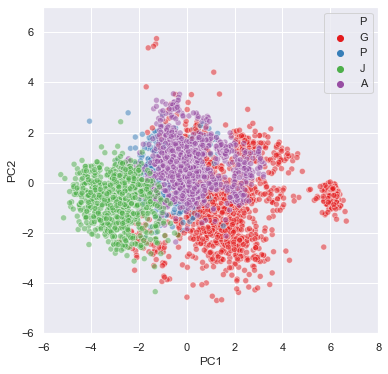

In [16]:
pca = PCA(n_components = 9)
PrincipalComponents = pca.fit_transform(x)
pc_space = pd.DataFrame(data = PrincipalComponents, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
song_space = pd.concat([pc_space, song_data[['P','Pn','NT']], ],axis = 1)

fig = plt.figure(figsize=(6,6));
sns.scatterplot(x = 'PC1',y = 'PC2',hue = 'P', alpha = 0.5, data = song_space, palette = 'Set1')
plt.xlim([-6,8]);
plt.ylim([-6,7]);
print('Explained Variance:',pca.explained_variance_ratio_)
print('Components:', pca.components_)

#### Song Space Occupied by the Prinia Species

In [17]:
song_space.head()
song_space.to_csv('song_space.csv')

Define the color map you want to use for the song-space plots

In [18]:
#defining an appropriate color map for future use
prinia_cmap = ListedColormap(sns.color_palette("Set1",4).as_hex())

To ensure proper 3d view, we define some useful functions

In [19]:
#defining functions for plotting 3d points in proper zorder

def get_camera_position(ax):
    """returns the camera position for 3D axes in cartesian coordinates"""
    r = np.square(ax.xy_viewLim.max).sum()
    theta, phi = np.radians((90 - ax.elev, ax.azim))
    return np.array(sph2cart(r, theta, phi), ndmin=2).T

def sph2cart(r, theta, phi):
    """spherical to cartesian transformation."""
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def reorder_camera_distance():
    """
    Sort the patches (via their offsets) by decreasing distance from camera position
    so that the furthest gets drawn first.
    """
    # camera position in xyz
    camera = get_camera_position(ax)
    # distance of patches from camera
    d = np.square(np.subtract(camera, patches._offsets3d)).sum(0)
    o = d.argsort()[::-1]

    patches._offsets3d = tuple(np.array(patches._offsets3d)[:, o])
    patches._facecolor3d = patches._facecolor3d[o]
    patches._edgecolor3d = patches._edgecolor3d[o]
    # todo: similar for linestyles, linewidths, etc.... 

def on_draw(event):
    reorder_camera_distance()

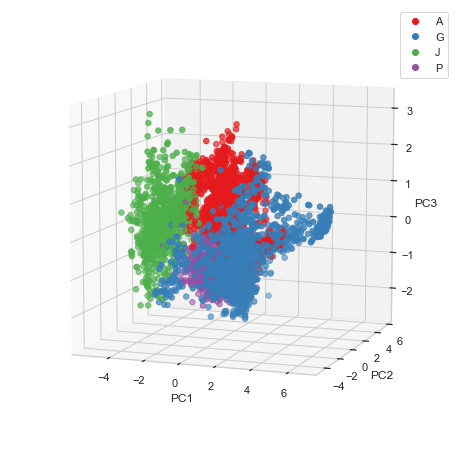

In [20]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(8,8))
classes = ['A','G','J','P']
ax = fig.add_subplot(111, projection='3d')
patches = ax.scatter(song_space['PC1'], song_space['PC2'], song_space['PC3'],\
                     c = song_space['Pn'], cmap = prinia_cmap, s=30)

plt.legend(handles=patches.legend_elements()[0], labels=classes)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.canvas.mpl_connect('draw_event', on_draw)

ax.view_init(10, 290)

plt.show()
sns.set();

Note that the 4 species seem to occupy different regions in song signal space

#### Train Linear Discriminant Classifier and check for overlap
Accuracy of k-fold cross validated LDA and confusion matrix:

In [21]:
clf = LinearDiscriminantAnalysis()
y_pred = cross_val_predict(clf,X,song_data['Pn'],cv = 10) #10 fold cross validation
accuracy = cross_val_score(clf,X,song_data['Pn'],cv = 10)
np.mean(accuracy)*100

93.08246706294427

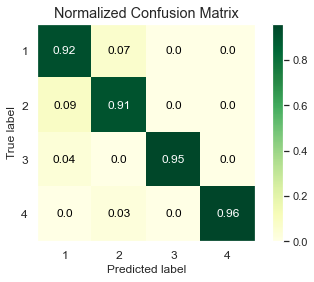

In [22]:
conf_mat = skplt.metrics.plot_confusion_matrix(y,y_pred, normalize = True, cmap = 'YlGn')
sns.set();

#### Randomization analyses using PC scores

**1. Shuffling Analysis**

Calculating mean interspecies euclidean distances in song space:

In [23]:
n = 3 #or 9 (No. of PCs to be considered for the randomization)

In [24]:
dist_a_g = sp.spatial.distance.cdist(song_space.iloc[:,0:n][song_space['P']=='A'], song_space.iloc[:,0:n][song_space['P']=='G']).mean()
dist_a_j = sp.spatial.distance.cdist(song_space.iloc[:,0:n][song_space['P']=='A'], song_space.iloc[:,0:n][song_space['P']=='J']).mean()
dist_a_p = sp.spatial.distance.cdist(song_space.iloc[:,0:n][song_space['P']=='A'], song_space.iloc[:,0:n][song_space['P']=='P']).mean()
dist_g_j = sp.spatial.distance.cdist(song_space.iloc[:,0:n][song_space['P']=='G'], song_space.iloc[:,0:n][song_space['P']=='J']).mean()
dist_g_p = sp.spatial.distance.cdist(song_space.iloc[:,0:n][song_space['P']=='G'], song_space.iloc[:,0:n][song_space['P']=='P']).mean()
dist_j_p = sp.spatial.distance.cdist(song_space.iloc[:,0:n][song_space['P']=='J'], song_space.iloc[:,0:n][song_space['P']=='P']).mean()
dist = np.mean([dist_a_g, dist_a_j, dist_a_p, dist_g_j, dist_g_p, dist_j_p])
[dist_a_g, dist_a_j, dist_a_p, dist_g_j, dist_g_p, dist_j_p, dist]

[3.664387948341443,
 3.821712954917969,
 2.5644411945449113,
 5.423943732565752,
 3.5851924382295635,
 3.43563114149401,
 3.7492182350156082]

In [25]:
song_space_s = song_space.copy()

In [26]:
song_space_s[['Pn','P']] = shuffle(song_space_s[['Pn','P']]).reset_index(drop = True)

Sample 3D song space on shuffling:

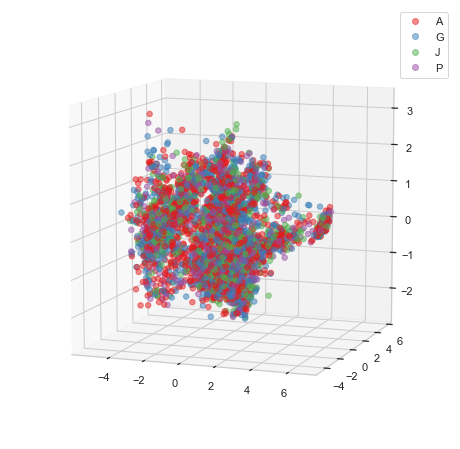

In [27]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(8,8))
classes = ['A','G','J','P']
ax = fig.add_subplot(111, projection='3d')
patches = ax.scatter(song_space_s['PC1'], song_space_s['PC2'], song_space_s['PC3'],\
                     c = song_space_s['Pn'], cmap = prinia_cmap, s=30, alpha = 0.5)

plt.legend(handles=patches.legend_elements()[0], labels=classes)

fig.canvas.mpl_connect('draw_event', on_draw)
ax.view_init(10, 290)

plt.show()
sns.set();

**Randomly shuffled space constructed N times**

Distribution of mean interspecific distance and observed mean interspecific distance:

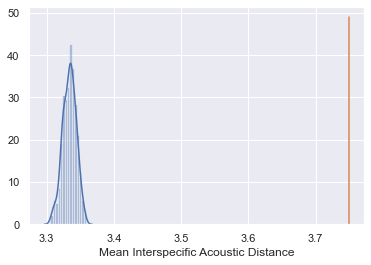

Z = 41.416627698951594
p = 0.0


In [28]:
#run simulations N times to get a distribution of interspecies distances
N = 500
dist_dist = pd.DataFrame(data = np.ones([N,7]), columns = ['AG','AJ','AP','GJ','GP','JP','mean'])
for i in range(N):
    song_space_s[['Pn','P']] = shuffle(song_space_s[['Pn','P']]).reset_index(drop = True)
    dist_dist.iloc[i,0] = sp.spatial.distance.cdist(song_space_s.iloc[:,0:n][song_space_s['P']=='A'], song_space_s.iloc[:,0:n][song_space_s['P']=='G']).mean()
    dist_dist.iloc[i,1] = sp.spatial.distance.cdist(song_space_s.iloc[:,0:n][song_space_s['P']=='A'], song_space_s.iloc[:,0:n][song_space_s['P']=='J']).mean()
    dist_dist.iloc[i,2] = sp.spatial.distance.cdist(song_space_s.iloc[:,0:n][song_space_s['P']=='A'], song_space_s.iloc[:,0:n][song_space_s['P']=='P']).mean()
    dist_dist.iloc[i,3] = sp.spatial.distance.cdist(song_space_s.iloc[:,0:n][song_space_s['P']=='G'], song_space_s.iloc[:,0:n][song_space_s['P']=='J']).mean()
    dist_dist.iloc[i,4] = sp.spatial.distance.cdist(song_space_s.iloc[:,0:n][song_space_s['P']=='G'], song_space_s.iloc[:,0:n][song_space_s['P']=='P']).mean()
    dist_dist.iloc[i,5] = sp.spatial.distance.cdist(song_space_s.iloc[:,0:n][song_space_s['P']=='J'], song_space_s.iloc[:,0:n][song_space_s['P']=='P']).mean()
    dist_dist.iloc[i,6] = np.mean(dist_dist.iloc[i,:6])
    
sns.distplot(dist_dist['mean'])
y = np.arange(0,N/10,1)
x = dist*np.ones(np.shape(y))
plt.plot(x,y);
plt.xlabel('Mean Interspecific Acoustic Distance')
plt.show()

m = np.mean(dist_dist['mean']); s = np.std(dist_dist['mean']);
Z = (dist-m)/s
p = sp.stats.norm.sf(abs(Z))
print('Z =',Z)
print('p =',p)

**2. Randomly sampling points from normal distributions**

In [29]:
song_space_r = song_space.copy()

In [30]:
for i in range(n):
    mu,sigma = norm.fit(song_space.iloc[:,i])
    song_space_r.iloc[:,i] = np.random.normal(mu, sigma, song_space_r.shape[0])

Sample 3D song space on randomization:

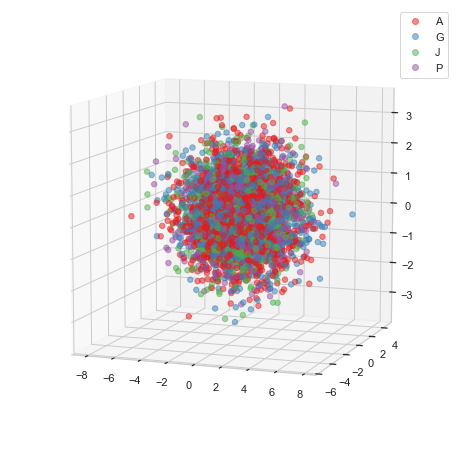

In [31]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(8,8))
classes = ['A','G','J','P']
ax = fig.add_subplot(111, projection='3d')
patches = ax.scatter(song_space_r['PC1'], song_space_r['PC2'], song_space_r['PC3'],\
                     c = song_space_r['Pn'], cmap = prinia_cmap, s=30, alpha = 0.5)

plt.legend(handles=patches.legend_elements()[0], labels=classes)

fig.canvas.mpl_connect('draw_event', on_draw)
ax.view_init(10, 290)

plt.show()
sns.set();

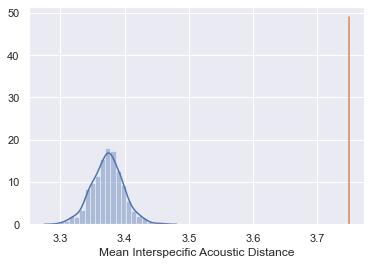

Z = 15.344505255248492
p = 1.9274352748206158e-53


In [32]:
#run simulations N times to get a distribution of interspecies distances
N = 500
dist_dist = pd.DataFrame(data = np.ones([N,7]), columns = ['AG','AJ','AP','GJ','GP','JP','mean'])
for i in range(N):
    for j in range(n):
        mu,sigma = norm.fit(song_space.iloc[:,j])
        song_space_r.iloc[:,j] = np.random.normal(mu, sigma, song_space_r.shape[0])
    dist_dist.iloc[i,0] = sp.spatial.distance.cdist(song_space_r.iloc[:,0:n][song_space_r['P']=='A'], song_space_r.iloc[:,0:n][song_space_r['P']=='G']).mean()
    dist_dist.iloc[i,1] = sp.spatial.distance.cdist(song_space_r.iloc[:,0:n][song_space_r['P']=='A'], song_space_r.iloc[:,0:n][song_space_r['P']=='J']).mean()
    dist_dist.iloc[i,2] = sp.spatial.distance.cdist(song_space_r.iloc[:,0:n][song_space_r['P']=='A'], song_space_r.iloc[:,0:n][song_space_r['P']=='P']).mean()
    dist_dist.iloc[i,3] = sp.spatial.distance.cdist(song_space_r.iloc[:,0:n][song_space_r['P']=='G'], song_space_r.iloc[:,0:n][song_space_r['P']=='J']).mean()
    dist_dist.iloc[i,4] = sp.spatial.distance.cdist(song_space_r.iloc[:,0:n][song_space_r['P']=='G'], song_space_r.iloc[:,0:n][song_space_r['P']=='P']).mean()
    dist_dist.iloc[i,5] = sp.spatial.distance.cdist(song_space_r.iloc[:,0:n][song_space_r['P']=='J'], song_space_r.iloc[:,0:n][song_space_r['P']=='P']).mean()
    dist_dist.iloc[i,6] = np.mean(dist_dist.iloc[i,:6])
    
sns.distplot(dist_dist['mean']) #all other parameters like dist_a_g etc. should also be tested
y = np.arange(0,N/10,1)
x = dist*np.ones(np.shape(y))
plt.plot(x,y);
plt.xlabel('Mean Interspecific Acoustic Distance')
plt.show()

m = np.mean(dist_dist['mean']); s = np.std(dist_dist['mean']);
Z = (dist-m)/s
p = sp.stats.norm.sf(abs(Z))
print('Z =',Z)
print('p =',p)

**Train a Linear Discriminant Classifier on Call Space**

Accuracy and Confusion Matrix of LDA on Call Space:

In [33]:
features = ['AE', 'BW', 'CF', 'DT', 'PF', 'PFCs', 'PFCe', 'PFCM', 'PFCm']
X = call_data.loc[:,features].values
y = call_data['Pn']
y_pred = cross_val_predict(clf,X,call_data['Pn'],cv = 10) #10 fold cross validation
accuracy = cross_val_score(clf,X,call_data['Pn'],cv = 10)
np.mean(accuracy)*100

91.57807308970101

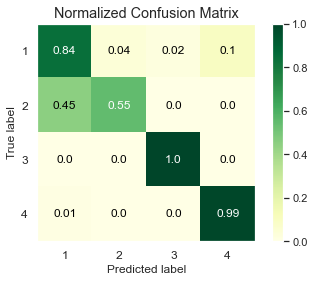

In [34]:
conf_mat = skplt.metrics.plot_confusion_matrix(y,y_pred, normalize = True, cmap = 'YlGn')
sns.set();

**Confirm that each PC axis is normally distributed**

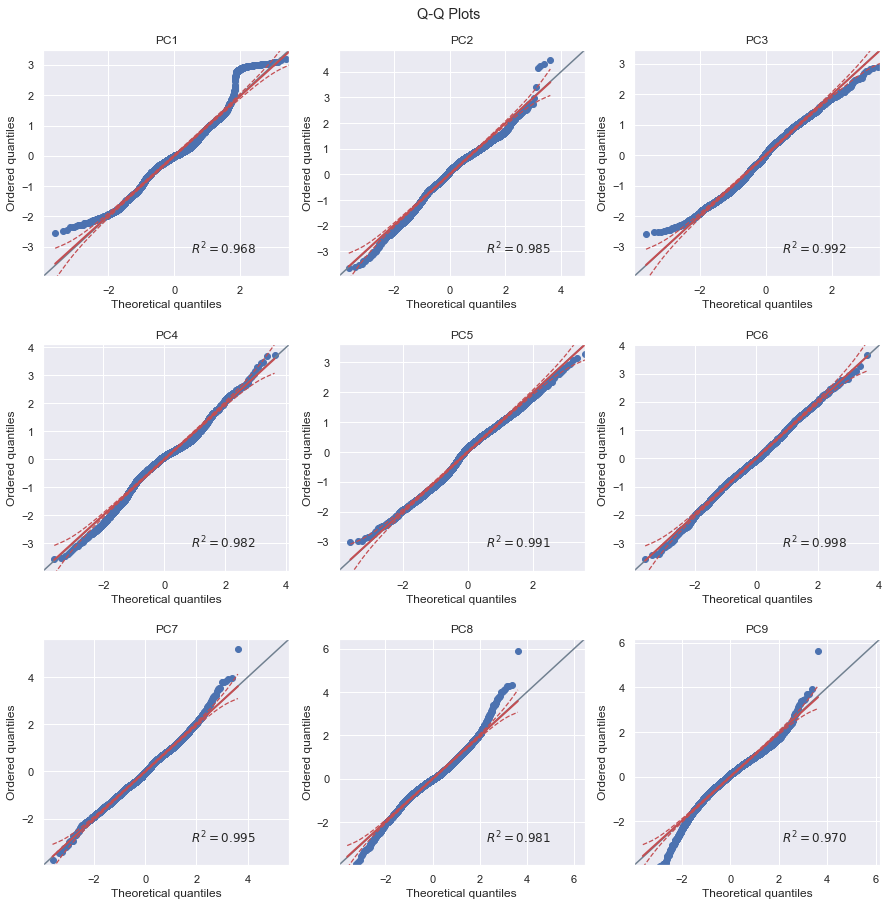

In [35]:
fig, ax = plt.subplots(figsize = (15,15), ncols=3, nrows=3)

plt.subplots_adjust(wspace  =  0.2, hspace  =  0.3)

pg.qqplot(song_space['PC1'], ax = ax[0][0]);
pg.qqplot(song_space['PC2'], ax = ax[0][1]);
pg.qqplot(song_space['PC3'], ax = ax[0][2]);
pg.qqplot(song_space['PC4'], ax = ax[1][0]);
pg.qqplot(song_space['PC5'], ax = ax[1][1]);
pg.qqplot(song_space['PC6'], ax = ax[1][2]);
pg.qqplot(song_space['PC7'], ax = ax[2][0]);
pg.qqplot(song_space['PC8'], ax = ax[2][1]);
pg.qqplot(song_space['PC9'], ax = ax[2][2]);

plt.suptitle('Q-Q Plots', y = 0.92)
ax[0][0].set_title("PC1"); ax[0][1].set_title("PC2"); ax[0][2].set_title("PC3");
ax[1][0].set_title("PC4"); ax[1][1].set_title("PC5"); ax[1][2].set_title("PC6");
ax[2][0].set_title("PC7"); ax[2][1].set_title("PC8"); ax[2][2].set_title("PC9");

## Part 2: Visualizing Note Space for 4 Species of Wren-Warblers

### Ashy Prinia Note Space

In [36]:
ashy_prinia_song_space = song_space[song_space['P']=='A'].reset_index(drop = True)
ashy_prinia_song_space[['NT']] = ashy_prinia_song_space[['NT']].astype('int')

In [37]:
def renumber(NT):
    m = np.unique(NT)
    n = np.arange(0,len(m),1)
    g = NT.copy()
    for i in n:
           g[NT==m[i]] = i+1
    NT = g
    return NT

In [38]:
#renumber Ashy Prinia Notes
ashy_prinia_song_space[['NT']] = renumber(ashy_prinia_song_space[['NT']])

#### Ashy Prinia Note Space in 2D

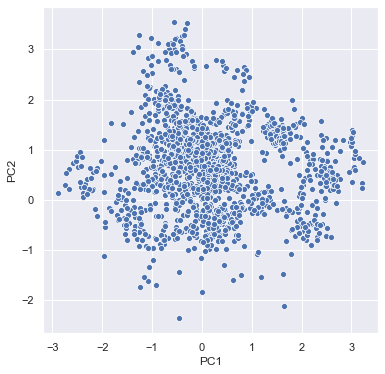

In [39]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2',data = ashy_prinia_song_space);

#### Ashy Prinia Annotated Note Space (based on preliminary visual inspection of spectrogram)
The annotations were imported along with the rest of the parameters as labels from Raven Pro

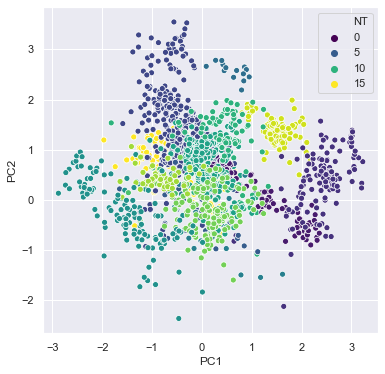

In [40]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'NT',data = ashy_prinia_song_space,palette = 'viridis');

#### Clubbing Note Types Visually to get main clusters (on careful inspection of spectrograms)

In [41]:
filename = 'visual_clustering_from_spectrogram_ashy.csv'
ashy_prinia_song_space['Visual Clusters'] = pd.read_csv(filename); ashy_prinia_song_space['Visual Clusters'] = ashy_prinia_song_space['Visual Clusters'].astype('int')

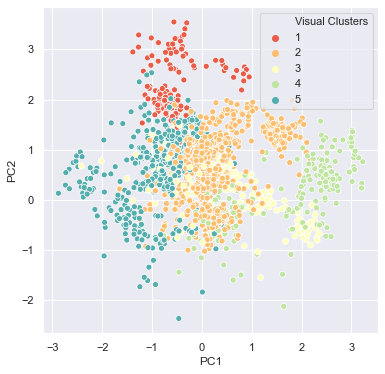

In [42]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'Visual Clusters', data = ashy_prinia_song_space, palette = sns.color_palette("Spectral", ashy_prinia_song_space['Visual Clusters'].nunique()));

#### Hierarchical Clustering
Agglomerative clustering using wald method with number of clusters specified

In [43]:
PCs = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']
X = ashy_prinia_song_space.loc[:,PCs].values
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
ashy_prinia_song_space['NTcl'] = cluster.fit_predict(X)

ashy_prinia_song_space[['Visual Clusters','NTcl','NT']] = ashy_prinia_song_space[['Visual Clusters','NTcl','NT']].astype('int')

In [44]:
#relabel clusters to align them with visual clusters (by looking at the PC1-PC2 graph)
ashy_prinia_song_space[['NTcl']] = ashy_prinia_song_space[['NTcl']].replace({0:20, 1:30, 2:40, 3:10, 4:50}).astype('int')
ashy_prinia_song_space[['NTcl']] = ashy_prinia_song_space[['NTcl']].replace({10:1, 20:2, 30:3, 40:4, 50:5})

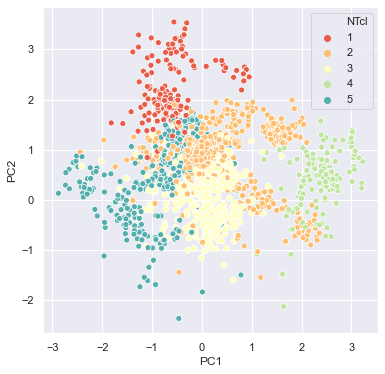

In [45]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'NTcl', data = ashy_prinia_song_space, palette = sns.color_palette("Spectral", ashy_prinia_song_space['NTcl'].nunique()));

Plot confusion matrix of the visually obtained clusters and the hierarchical clusters

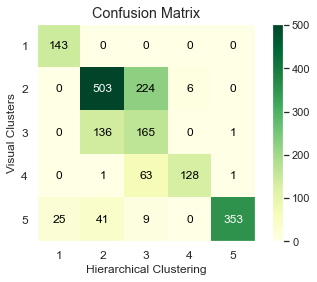

In [46]:
conf_mat = skplt.metrics.plot_confusion_matrix(ashy_prinia_song_space['Visual Clusters'],ashy_prinia_song_space['NTcl'], cmap = 'YlGn')
plt.ylabel('Visual Clusters'); plt.xlabel('Hierarchical Clustering')
sns.set();

#### PCA on the Ashy Prinia Dataset to visualize clusters

In [47]:
ashy_prinia_song_data = song_data[song_data['P']=='A'].reset_index(drop = True)

In [48]:
X = ashy_prinia_song_data.loc[:,features].values
y = ashy_prinia_song_data.loc[:,['Pn']].values
x = StandardScaler().fit_transform(X)

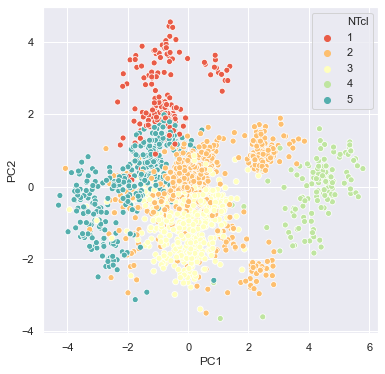

In [49]:
pca = PCA(n_components = 9)
PrincipalComponents = pca.fit_transform(x)
pc_space = pd.DataFrame(data = PrincipalComponents, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
ashy_prinia_song_space_pc = pd.concat([pc_space, ashy_prinia_song_space[['Visual Clusters','NTcl']]],axis = 1)

fig = plt.figure(figsize=(6,6));
sns.scatterplot(x = 'PC1',y = 'PC2',hue = 'NTcl', data = ashy_prinia_song_space_pc, palette = sns.color_palette("Spectral", ashy_prinia_song_space_pc['NTcl'].nunique()));

#### Hierarchical Clustering on the scores of the PCA performed on the Ashy Prinia Dataset

In [50]:
X = ashy_prinia_song_space_pc.loc[:,PCs].values
cluster = AgglomerativeClustering(n_clusters=len(np.unique(ashy_prinia_song_space['Visual Clusters'])), affinity='euclidean', linkage='ward')
ashy_prinia_song_space_pc['NTcl_pc'] = cluster.fit_predict(X)

ashy_prinia_song_space_pc[['NTcl_pc']] = ashy_prinia_song_space_pc[['NTcl_pc']].replace({0:20, 1:40, 2:50, 3:10, 4:30}).astype('int')
ashy_prinia_song_space_pc[['NTcl_pc']] = ashy_prinia_song_space_pc[['NTcl_pc']].replace({10:1, 20:2, 30:3, 40:4, 50:5})

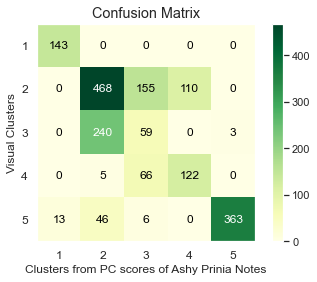

In [51]:
#comparing visual clusters to hierarchical clusters from PC scores of Ashy Prinia notes
conf_mat = skplt.metrics.plot_confusion_matrix(ashy_prinia_song_space_pc['Visual Clusters'],ashy_prinia_song_space_pc['NTcl_pc'], cmap = 'YlGn')
plt.ylabel('Visual Clusters'); plt.xlabel('Clusters from PC scores of Ashy Prinia Notes')
sns.set();

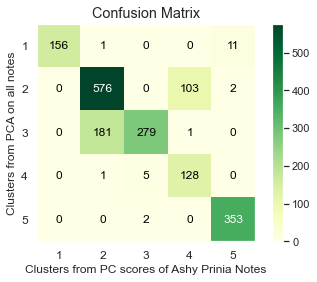

In [52]:
#comparing hierarchical clusters from PCA on all notes to hierarchical clusters from PC scores of Ashy Prinia notes
conf_mat = skplt.metrics.plot_confusion_matrix(ashy_prinia_song_space_pc['NTcl'],ashy_prinia_song_space_pc['NTcl_pc'], cmap = 'YlGn')
plt.ylabel('Clusters from PCA on all notes'); plt.xlabel('Clusters from PC scores of Ashy Prinia Notes')
sns.set();

#### Final Note Types and Visualization of Note Space

In [53]:
def grouper(NT,NTcl):
    mat = pd.DataFrame(confusion_matrix(NT,NTcl))
    f_NT = NT.copy()
    for i in range(len(mat)):
        M = np.max(mat.iloc[i,:])
        idx = mat[mat.iloc[i,:]==M].index.tolist()[0]+1
        f_NT[NT==i+1] = idx
    return f_NT

In [54]:
#grouping preserves original annotation by eye and also incorporates higher order clusters
ashy_prinia_song_space_pc[['f_NT']] = grouper(ashy_prinia_song_space[['NT']], ashy_prinia_song_space[['NTcl']])
#also try grouping with Visual Clusters and NTcl_pc to see if the similar results are obtained
#ashy_prinia_song_space_pc[['f_NT']] = grouper(ashy_prinia_song_space[['NT']], ashy_prinia_song_space_pc[['NTcl_pc']])
#ashy_prinia_song_space_pc[['f_NT']] = grouper(ashy_prinia_song_space[['NT']], ashy_prinia_song_space[['Visual Clusters']])

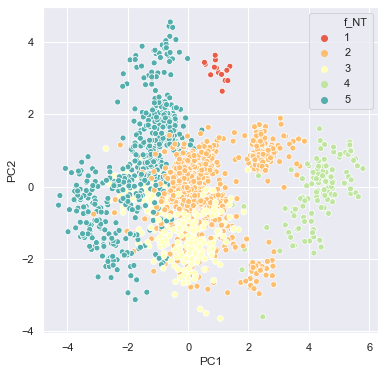

In [55]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'f_NT', data = ashy_prinia_song_space_pc, palette = sns.color_palette("Spectral", ashy_prinia_song_space_pc['f_NT'].nunique()));

### Grey Breasted Prinia Note Space

In [56]:
gb_prinia_song_space = song_space[song_space['P']=='G'].reset_index(drop = True)
gb_prinia_song_space[['NT']] = gb_prinia_song_space[['NT']].astype('int')

In [57]:
#renumber Grey Breasted Prinia Notes
gb_prinia_song_space[['NT']] = renumber(gb_prinia_song_space[['NT']])

#### Grey Breasted Prinia Note Space in 2d

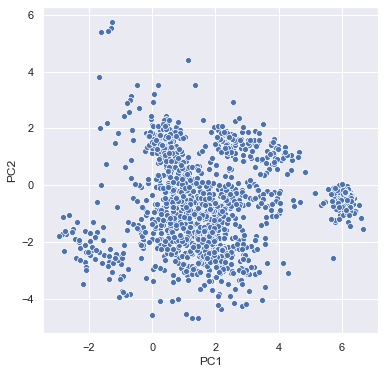

In [58]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2',data = gb_prinia_song_space);

#### Annotated Note Types

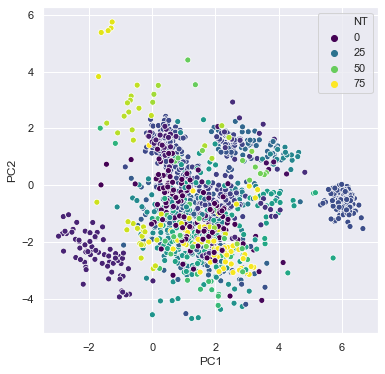

In [59]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'NT',data = gb_prinia_song_space,palette = 'viridis');

#### Visual Clustering

In [60]:
filename = 'visual_clustering_from_spectrogram_greybreasted.csv'
gb_prinia_song_space['Visual Clusters'] = pd.read_csv(filename); gb_prinia_song_space['Visual Clusters'] = gb_prinia_song_space['Visual Clusters'].astype('int')

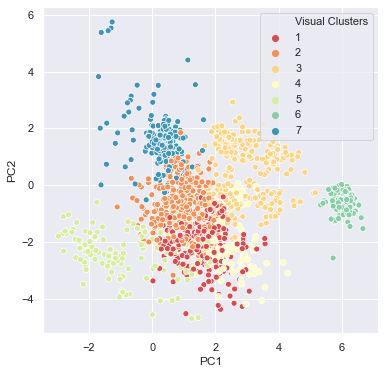

In [61]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'Visual Clusters', data = gb_prinia_song_space, palette = sns.color_palette("Spectral", gb_prinia_song_space['Visual Clusters'].nunique()));

#### Hierarchical Clustering

In [62]:
PCs = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']
X = gb_prinia_song_space.loc[:,PCs].values
cluster = AgglomerativeClustering(n_clusters=len(np.unique(gb_prinia_song_space['Visual Clusters'])), affinity='euclidean', linkage='ward')
gb_prinia_song_space['NTcl'] = cluster.fit_predict(X)

In [63]:
#relabel clusters to align them with visual clusters (by looking at the PC1-PC2 graph)
gb_prinia_song_space[['NTcl']] = gb_prinia_song_space[['NTcl']].replace({0:10, 1:50, 2:70, 3:60, 4:30, 5:20, 6:40}).astype('int')
gb_prinia_song_space[['NTcl']] = gb_prinia_song_space[['NTcl']].replace({10:1, 20:2, 30:3, 40:4, 50:5, 60:6, 70:7})

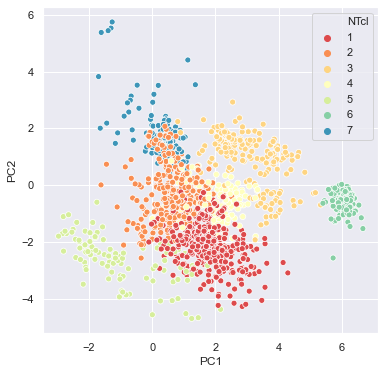

In [64]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'NTcl', data = gb_prinia_song_space, palette = sns.color_palette("Spectral", gb_prinia_song_space['NTcl'].nunique()));

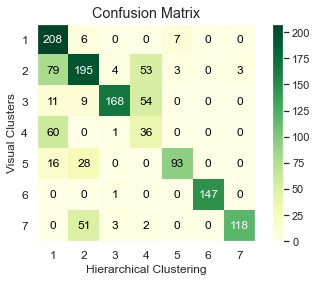

In [65]:
#plot confusion matrix of the visually obtained clusters and the hierarchical clusters
conf_mat = skplt.metrics.plot_confusion_matrix(gb_prinia_song_space['Visual Clusters'],gb_prinia_song_space['NTcl'], cmap = 'YlGn')
plt.ylabel('Visual Clusters'); plt.xlabel('Hierarchical Clustering')
sns.set();

#### PCA on the Grey Breasted Prinia Dataset

In [66]:
gb_prinia_song_data = song_data[song_data['P']=='G'].reset_index(drop = True)
gb_prinia_song_data.head()

,AE,BW,CF,DT,PF,PFCs,PFCe,PFCM,PFCm,Pn,SC,P,NT
0,3.946,1464.3,5512.5,0.074172,5598.6,5943.2,4478.9,6373.8,3962.1,2,S,G,19.0
1,3.905,1378.1,5254.1,0.087971,5340.2,5684.8,4048.2,5943.2,4048.2,2,S,G,19.0
2,3.690,1378.1,5512.5,0.081072,5598.6,5598.6,4737.3,6287.7,4737.3,2,S,G,19.0
3,3.849,1722.7,5512.5,0.087971,5598.6,6029.3,5340.2,6632.2,5081.8,2,S,G,19.0
4,3.824,2670.1,5426.4,0.098321,5684.8,4048.2,3617.6,6890.6,3617.6,2,S,G,19.0


In [67]:
X = gb_prinia_song_data.loc[:,features].values
y = gb_prinia_song_data.loc[:,['Pn']].values
x = StandardScaler().fit_transform(X)

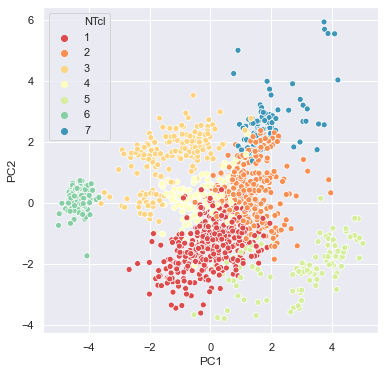

In [68]:
pca = PCA(n_components = 9)
PrincipalComponents = pca.fit_transform(x)
pc_space = pd.DataFrame(data = PrincipalComponents, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
gb_prinia_song_space_pc = pd.concat([pc_space, gb_prinia_song_space[['Visual Clusters','NTcl']]],axis = 1)

fig = plt.figure(figsize=(6,6));
sns.scatterplot(x = 'PC1',y = 'PC2',hue = 'NTcl', data = gb_prinia_song_space_pc, palette = sns.color_palette("Spectral", gb_prinia_song_space_pc['NTcl'].nunique()));

#### Hierarchical Clustering on the scores of the PCA performed on the Grey Breasted Prinia Dataset

In [69]:
X = gb_prinia_song_space_pc.loc[:,PCs].values
cluster = AgglomerativeClustering(n_clusters=len(np.unique(gb_prinia_song_space['Visual Clusters'])), affinity='euclidean', linkage='ward')
gb_prinia_song_space_pc['NTcl_pc'] = cluster.fit_predict(X)

gb_prinia_song_space_pc[['NTcl_pc']] = gb_prinia_song_space_pc[['NTcl_pc']].replace({0:10, 1:30, 2:40, 3:50, 4:60, 5:20, 6:70}).astype('int')
gb_prinia_song_space_pc[['NTcl_pc']] = gb_prinia_song_space_pc[['NTcl_pc']].replace({10:1, 20:2, 30:3, 40:4, 50:5, 60:6, 70:7})

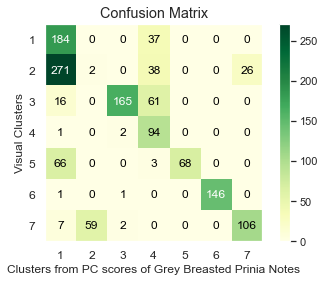

In [70]:
#comparing visual clusters to hierarchical clusters from PC scores of Ashy Prinia notes
conf_mat = skplt.metrics.plot_confusion_matrix(gb_prinia_song_space_pc['Visual Clusters'],gb_prinia_song_space_pc['NTcl_pc'], cmap = 'YlGn')
plt.ylabel('Visual Clusters'); plt.xlabel('Clusters from PC scores of Grey Breasted Prinia Notes')
sns.set();

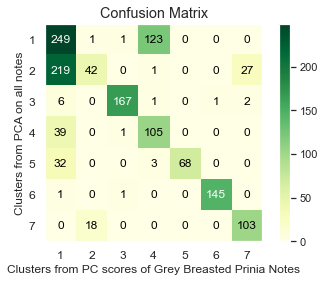

In [71]:
#comparing hierarchical clusters from PCA on all notes to hierarchical clusters from PC scores of Ashy Prinia notes
conf_mat = skplt.metrics.plot_confusion_matrix(gb_prinia_song_space_pc['NTcl'],gb_prinia_song_space_pc['NTcl_pc'], cmap = 'YlGn')
plt.ylabel('Clusters from PCA on all notes'); plt.xlabel('Clusters from PC scores of Grey Breasted Prinia Notes')
sns.set();

#### Final Note Types and Visualization of Note Space

In [72]:
#grouping preserves original annotation by eye and also incorporates higher order clusters
#gb_prinia_song_space_pc[['f_NT']] = grouper(gb_prinia_song_space[['NT']], gb_prinia_song_space[['NTcl']])
#also try grouping with Visual Clusters and NTcl_pc to see if the similar results are obtained
#gb_prinia_song_space_pc[['f_NT']] = grouper(gb_prinia_song_space[['NT']], gb_prinia_song_space_pc[['NTcl_pc']])
gb_prinia_song_space_pc[['f_NT']] = grouper(gb_prinia_song_space[['NT']], gb_prinia_song_space[['Visual Clusters']])

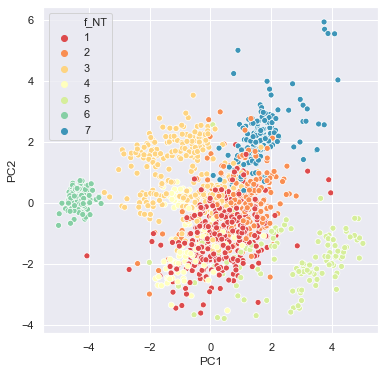

In [73]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'f_NT', data = gb_prinia_song_space_pc, palette = sns.color_palette("Spectral", gb_prinia_song_space_pc['f_NT'].nunique()));

### Jungle Prinia Song Space

In [74]:
jungle_prinia_song_space = song_space[song_space['P']=='J'].reset_index(drop = True)
jungle_prinia_song_space[['NT']] = jungle_prinia_song_space[['NT']].astype('int')

In [75]:
#renumber Jungle Prinia Notes
jungle_prinia_song_space[['NT']] = renumber(jungle_prinia_song_space[['NT']])

In [76]:
jungle_prinia_song_space.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,P,Pn,NT
0,-4.322682,-0.053507,-0.688034,0.036425,0.883712,0.339404,-0.488752,0.431656,-0.142296,J,3,1
1,-3.951238,-0.427518,-0.738489,0.318336,0.661828,0.219842,-0.031196,0.222081,0.066701,J,3,1
2,-4.240668,-0.416903,-0.264041,0.742556,0.049697,0.527922,0.269129,0.383776,-0.146549,J,3,1
3,-4.477789,-1.012366,-1.038682,0.288168,1.127604,0.496524,0.775139,0.126268,0.060291,J,3,1
4,-4.257792,-0.370490,-0.970352,0.044638,0.856221,0.404295,-0.202908,0.298447,-0.064618,J,3,1


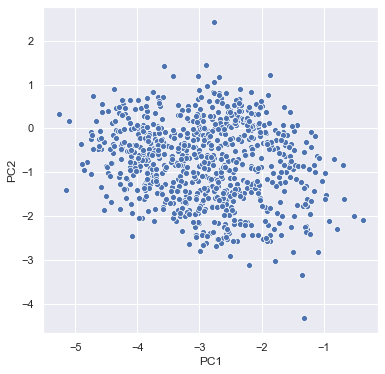

In [77]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2',data = jungle_prinia_song_space);

#### Annotated Note Types

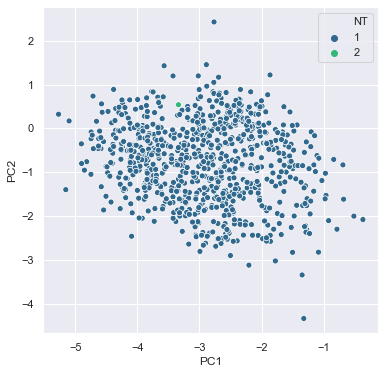

In [78]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'NT',data = jungle_prinia_song_space, palette = sns.color_palette("viridis", jungle_prinia_song_space['NT'].nunique()));

Note single large cluster

#### PCA on the Jungle Prinia Dataset

In [79]:
jungle_prinia_song_data = song_data[song_data['P']=='J'].reset_index(drop = True)

In [80]:
X = jungle_prinia_song_data.loc[:,features].values
y = jungle_prinia_song_data.loc[:,['Pn']].values
x = StandardScaler().fit_transform(X)

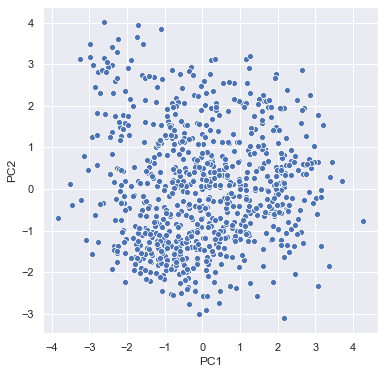

In [81]:
pca = PCA(n_components = 9)
PrincipalComponents = pca.fit_transform(x)
pc_space = pd.DataFrame(data = PrincipalComponents, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
jungle_prinia_song_space_pc = pc_space.copy()

fig = plt.figure(figsize=(6,6));
sns.scatterplot(x = 'PC1',y = 'PC2', data = jungle_prinia_song_space_pc);

### Plain Prinia Song Space

In [82]:
plain_prinia_song_space = song_space[song_space['P']=='P'].reset_index(drop = True)
plain_prinia_song_space[['NT']] = jungle_prinia_song_space[['NT']].astype('int')

In [83]:
#renumber Plain Prinia Notes
plain_prinia_song_space[['NT']] = renumber(plain_prinia_song_space[['NT']])

In [84]:
plain_prinia_song_space.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,P,Pn,NT
0,-0.264268,1.039096,-1.751431,0.065419,-0.727571,0.227991,0.334806,0.181303,0.047990,P,4,1
1,-1.098033,1.059949,-1.302956,-0.088507,-1.238720,0.296282,0.744882,-0.123047,-0.358640,P,4,1
2,-1.794493,-0.195060,-0.704548,-0.014273,-0.664909,0.165448,0.200581,0.174425,-0.641139,P,4,1
3,-1.024490,0.188662,-1.340289,0.259744,-1.001193,0.495131,0.142422,0.295998,0.511827,P,4,1
4,-1.569720,-0.351561,-1.492462,0.218632,-0.558188,-0.983659,0.829403,-0.135829,-0.178038,P,4,1


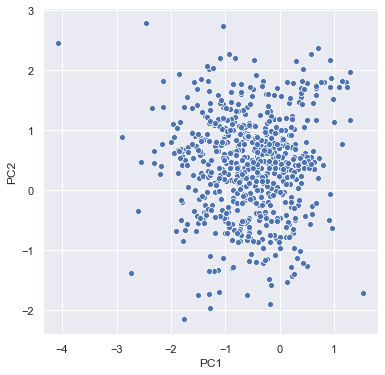

In [85]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2',data = plain_prinia_song_space);

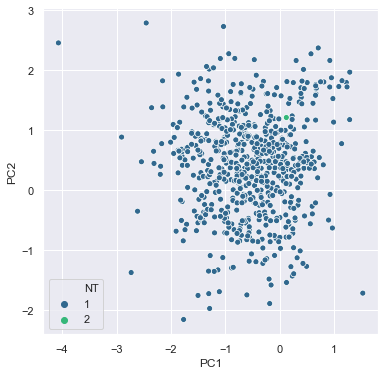

In [86]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x = 'PC1',y = 'PC2', hue = 'NT',data = plain_prinia_song_space,palette = sns.color_palette('viridis',plain_prinia_song_space['NT'].nunique()));

#### PCA on the Plain Prinia Dataset

In [87]:
plain_prinia_song_data = song_data[song_data['P']=='P'].reset_index(drop = True)

In [88]:
X = plain_prinia_song_data.loc[:,features].values
y = plain_prinia_song_data.loc[:,['Pn']].values
x = StandardScaler().fit_transform(X)

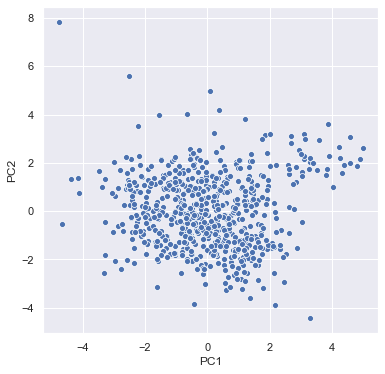

In [89]:
pca = PCA(n_components = 9)
PrincipalComponents = pca.fit_transform(x)
pc_space = pd.DataFrame(data = PrincipalComponents, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
plain_prinia_song_space_pc = pc_space.copy()

fig = plt.figure(figsize=(6,6));
sns.scatterplot(x = 'PC1',y = 'PC2', data = plain_prinia_song_space_pc);

## Part 3: Repetition Rate Analysis

In [90]:
jungle_rate = pd.DataFrame()
jungle_rate = df[['BT','ET']].loc[(df['SC']=='S')&(df['P']=='J')].reset_index(drop = True)
BT = np.array(jungle_rate['BT'].iloc[1:]); ET = np.array(jungle_rate['ET'].iloc[:-1]);
is_int_jungle = BT-ET
is_int_jungle = is_int_jungle[(is_int_jungle<0.3)&(is_int_jungle>0)]

plain_rate = pd.DataFrame()
plain_rate = df[['BT','ET']].loc[(df['SC']=='S')&(df['P']=='P')].reset_index(drop = True)
BT = np.array(plain_rate['BT'].iloc[1:]); ET = np.array(plain_rate['ET'].iloc[:-1]);
is_int_plain = BT-ET
is_int_plain = is_int_plain[(is_int_plain<0.3)&(is_int_plain>0)]

#### Distribution of Intersyllable Intervals for Ashy and Jungle Prinia

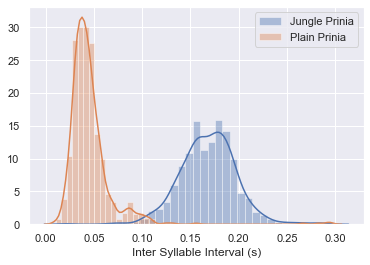

In [91]:
fig = plt.figure(figsize=(6,4))
sns.distplot(is_int_jungle)
sns.distplot(is_int_plain)
plt.xlabel('Inter Syllable Interval (s)')
plt.legend(['Jungle Prinia', 'Plain Prinia'])
plt.show()

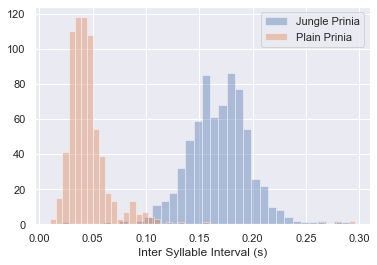

In [92]:
fig = plt.figure(figsize=(6,4))
sns.distplot(is_int_jungle, kde = False)
sns.distplot(is_int_plain, kde = False)
plt.xlabel('Inter Syllable Interval (s)')
plt.legend(['Jungle Prinia', 'Plain Prinia'])
plt.show()